In [16]:
import cantera as ct
import numpy as np

from scipy.integrate import trapz
import matplotlib.pyplot as plt

In [17]:
#########################################################################
# Input Parameters
#########################################################################

# # reaction mechanism, kinetics type and compositions

# reaction mechanism, kinetics type and compositions
# reaction_mechanism = 'nDodecane_Reitz.yaml'
reaction_mechanism = 'CRECK2003_C1.yaml'
# phase_name = 'nDodecane_IG'
comp_air = 'O2:1, N2:3.76'
comp_fuel = 'C2H5OH:1'

f = 3000. / 60.  # engine speed [1/s] (3000 rpm)
V_H = 1600e-6  # displaced volume [m**3]
epsilon = 18.  # compression ratio [-]
d_piston = 0.08  # piston diameter [m]

# turbocharger temperature, pressure, and composition
T_inlet = 400.  # K
p_inlet = 1.3e5  # Pa
comp_inlet = comp_air

# outlet pressure
p_outlet = 1.2e5  # Pa

# fuel properties (gaseous!)
T_injector = 300.  # K
p_injector = 1600e5  # Pa
comp_injector = comp_fuel

# ambient properties
T_ambient = 300.  # K
p_ambient = 1e5  # Pa
comp_ambient = comp_air

# Inlet valve friction coefficient, open and close timings
inlet_valve_coeff = 1.e-6
inlet_open = -18. / 180. * np.pi
inlet_close = 198. / 180. * np.pi

# Outlet valve friction coefficient, open and close timings
outlet_valve_coeff = 1.e-6
outlet_open = 522. / 180 * np.pi
outlet_close = 18. / 180. * np.pi

# Fuel mass, injector open and close timings
injector_open = 350. / 180. * np.pi
injector_close = 365. / 180. * np.pi
injector_mass = 3.2e-5  # kg

# Simulation time and parameters
sim_n_revolutions = 8
delta_T_max = 20.
rtol = 1.e-12
atol = 1.e-16

In [18]:
#####################################################################
# Set up IC engine Parameters and Functions
#####################################################################

V_oT = V_H / (epsilon - 1.)
A_piston = 0.25 * np.pi * d_piston ** 2
stroke = V_H / A_piston


def crank_angle(t):
    """Convert time to crank angle"""
    return np.remainder(2 * np.pi * f * t, 4 * np.pi)


def piston_speed(t):
    """Approximate piston speed with sinusoidal velocity profile"""
    return - stroke / 2 * 2 * np.pi * f * np.sin(crank_angle(t))

In [19]:
#####################################################################
# Set up Reactor Network
#####################################################################

# load reaction mechanism
gas = ct.Solution(reaction_mechanism)

# define initial state and set up reactor
gas.TPX = T_inlet, p_inlet, comp_inlet
cyl = ct.IdealGasReactor(gas)
cyl.volume = V_oT

# define inlet state
gas.TPX = T_inlet, p_inlet, comp_inlet
# Note: The previous line is technically not needed as the state of the gas object is
# already set correctly; change if inlet state is different from the reactor state.
inlet = ct.Reservoir(gas)

# inlet valve
inlet_valve = ct.Valve(inlet, cyl)
inlet_delta = np.mod(inlet_close - inlet_open, 4 * np.pi)
inlet_valve.valve_coeff = inlet_valve_coeff
inlet_valve.time_function = (lambda t: np.mod(crank_angle(t) - inlet_open, 4 * np.pi) < inlet_delta)

# define injector state (gaseous!)
gas.TPX = T_injector, p_injector, comp_injector
injector = ct.Reservoir(gas)

# injector is modeled as a mass flow controller
injector_mfc = ct.MassFlowController(injector, cyl)
injector_delta = np.mod(injector_close - injector_open, 4 * np.pi)
injector_t_open = (injector_close - injector_open) / 2. / np.pi / f
injector_mfc.mass_flow_coeff = injector_mass / injector_t_open
injector_mfc.time_function = (lambda t: np.mod(crank_angle(t) - injector_open, 4 * np.pi) < injector_delta)

# define outlet pressure (temperature and composition don't matter)
gas.TPX = T_ambient, p_outlet, comp_ambient
outlet = ct.Reservoir(gas)

# outlet valve
outlet_valve = ct.Valve(cyl, outlet)
outlet_delta = np.mod(outlet_close - outlet_open, 4 * np.pi)
outlet_valve.valve_coeff = outlet_valve_coeff
outlet_valve.time_function = (lambda t: np.mod(crank_angle(t) - outlet_open, 4 * np.pi) < outlet_delta)

# define ambient pressure (temperature and composition don't matter)
gas.TPX = T_ambient, p_ambient, comp_ambient
ambient_air = ct.Reservoir(gas)

# piston is modeled as a moving wall
piston = ct.Wall(ambient_air, cyl)
piston.area = A_piston
piston.velocity = piston_speed

# create a reactor network containing the cylinder and limit advance step
sim = ct.ReactorNet([cyl])
sim.rtol, sim.atol = rtol, atol
cyl.set_advance_limit('temperature', delta_T_max)

In [20]:
#####################################################################
# Run Simulation
#####################################################################

# set up output data arrays
states = ct.SolutionArray(
    cyl.thermo,
    extra=('t', 'ca', 'V', 'm', 'mdot_in', 'mdot_out', 'dWv_dt'),
)

# simulate with a maximum resolution of 1 deg crank angle
dt = 0.1 * 1. / (360 * f)
t_stop = sim_n_revolutions / f
while sim.time < t_stop:

    # perform time integration
    sim.advance(sim.time + dt)

    # calculate results to be stored
    dWv_dt = - (cyl.thermo.P - ambient_air.thermo.P) * A_piston * \
        piston_speed(sim.time)

    # append output data
    states.append(cyl.thermo.state,
                  t=sim.time, ca=crank_angle(sim.time),
                  V=cyl.volume, m=cyl.mass,
                  mdot_in=inlet_valve.mass_flow_rate,
                  mdot_out=outlet_valve.mass_flow_rate,
                  dWv_dt=dWv_dt)

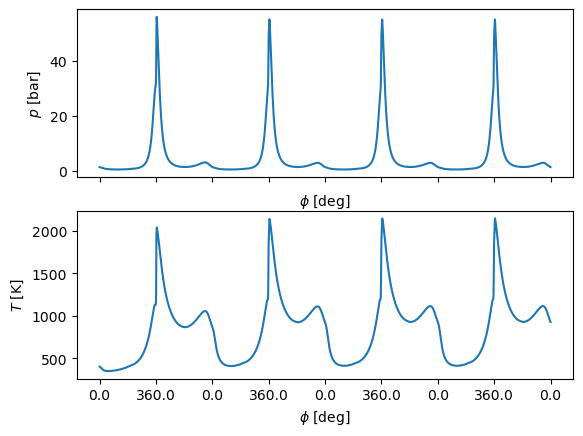

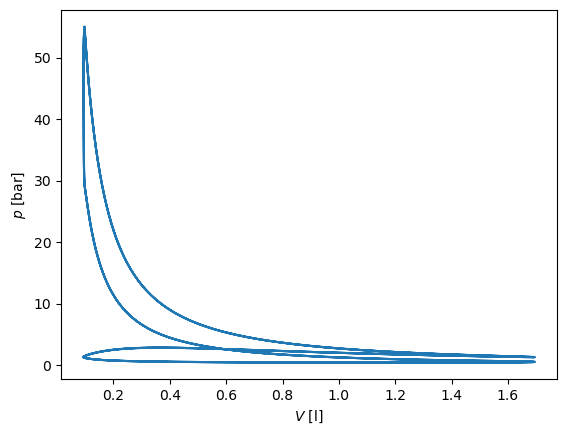

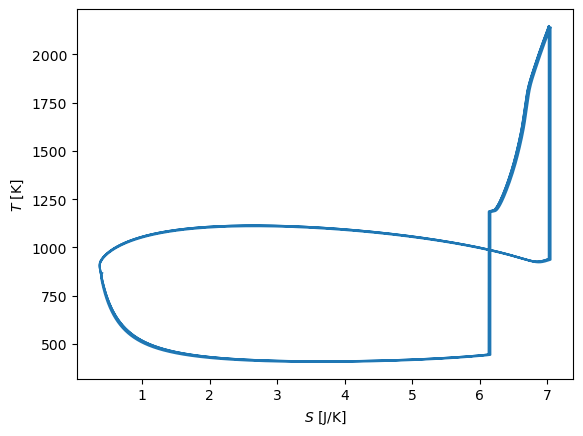

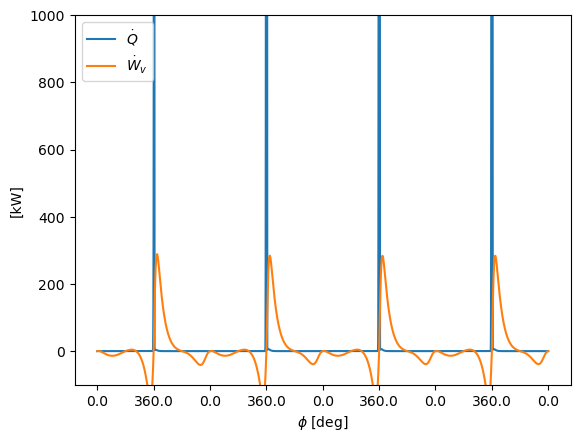

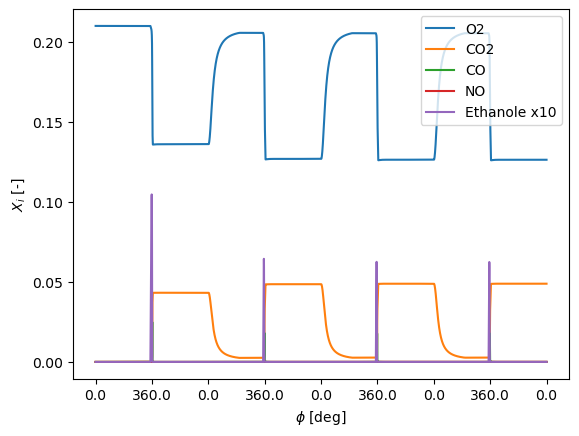

In [21]:
#######################################################################
# Plot Results in matplotlib
#######################################################################

def ca_ticks(t):
    """Helper function converts time to rounded crank angle."""
    return np.round(crank_angle(t) * 180 / np.pi, decimals=1)


t = states.t

# pressure and temperature
xticks = np.arange(0, 0.18, 0.02)
fig, ax = plt.subplots(nrows=2)
ax[0].plot(t, states.P / 1.e5)
ax[0].set_ylabel('$p$ [bar]')
ax[0].set_xlabel(r'$\phi$ [deg]')
ax[0].set_xticklabels([])
ax[1].plot(t, states.T)
ax[1].set_ylabel('$T$ [K]')
ax[1].set_xlabel(r'$\phi$ [deg]')
ax[1].set_xticks(xticks)
ax[1].set_xticklabels(ca_ticks(xticks))
plt.show()

# p-V diagram
fig, ax = plt.subplots()
ax.plot(states.V[t > 0.04] * 1000, states.P[t > 0.04] / 1.e5)
ax.set_xlabel('$V$ [l]')
ax.set_ylabel('$p$ [bar]')
plt.show()

# T-S diagram
fig, ax = plt.subplots()
ax.plot(states.m[t > 0.04] * states.s[t > 0.04], states.T[t > 0.04])
ax.set_xlabel('$S$ [J/K]')
ax.set_ylabel('$T$ [K]')
plt.show()

# heat of reaction and expansion work
fig, ax = plt.subplots()
ax.plot(t, 1.e-3 * states.heat_release_rate * states.V, label=r'$\dot{Q}$')
ax.plot(t, 1.e-3 * states.dWv_dt, label=r'$\dot{W}_v$')
ax.set_ylim(-1e2, 1e3)
ax.legend(loc=0)
ax.set_ylabel('[kW]')
ax.set_xlabel(r'$\phi$ [deg]')
ax.set_xticks(xticks)
ax.set_xticklabels(ca_ticks(xticks))
plt.show()

# gas composition
fig, ax = plt.subplots()
ax.plot(t, states('o2').X, label='O2')
ax.plot(t, states('co2').X, label='CO2')
ax.plot(t, states('co').X, label='CO')
ax.plot(t, states('no').X, label='NO')
ax.plot(t, states('C2H5OH').X * 10, label='Ethanole x10')
ax.legend(loc=0)
ax.set_ylabel('$X_i$ [-]')
ax.set_xlabel(r'$\phi$ [deg]')
ax.set_xticks(xticks)
ax.set_xticklabels(ca_ticks(xticks))
plt.show()

In [22]:
######################################################################
# Integral Results
######################################################################

# heat release
Q = trapz(states.heat_release_rate * states.V, t)
output_str = '{:45s}{:>4.1f} {}'
print(output_str.format('Heat release rate per cylinder (estimate):', Q / t[-1] / 1000., 'kW'))

# expansion power
W = trapz(states.dWv_dt, t)
print(output_str.format('Expansion power per cylinder (estimate):', W / t[-1] / 1000., 'kW'))

# efficiency
eta = W / Q
print(output_str.format('Efficiency (estimate):', eta * 100., '%'))

# CO emissions
MW = states.mean_molecular_weight
CO_emission = trapz(MW * states.mdot_out * states('NO').X[:, 0], t)
CO_emission /= trapz(MW * states.mdot_out, t)
print(output_str.format('NO emission (estimate):', CO_emission * 1.e6, 'ppm'))

Heat release rate per cylinder (estimate):   22.3 kW
Expansion power per cylinder (estimate):      6.8 kW
Efficiency (estimate):                       30.4 %
NO emission (estimate):                      51.8 ppm
